# PROJEKT 2 - ANALIZA OBRAZÓW DNA OKA (SEGMENTACJA OBRAZU)

Celem projektu jest stworzenie systemu służącego do segmentacji (wykrywania) naczyń krwionośnych w obrazach dna oka oraz wykonanie eksperymentów weryfikujących jakość segmentacji.

![title](pictures/EYE.png)

Import wykorzystanych w projekcie bibliotek:

In [2]:
from pylab import *
from skimage import img_as_float
from skimage.color import rgb2gray

In [3]:
folder = 'pictures/'
images = ['im0001.ppm', 'im0002.ppm', 'im0003.ppm', 'im0004.ppm', 'im0005.ppm', 'im0044.ppm', 'im0077.ppm',
          'im0081.ppm', 'im0082.ppm', 'im0139.ppm', 'im0162.ppm', 'im0163.ppm', 'im0235.ppm', 'im0236.ppm',
          'im0239.ppm', 'im0240.ppm', 'im0255.ppm', 'im0291.ppm', 'im0319.ppm', 'im0324.ppm']

Funkacja pomocnicza wyświetlająca pobrany jako argument obraz w odpowiednim miejscu:

In [4]:
def show_image(image, position):
    subplot(position[0], position[1], position[2])
    plt.axis('off')
    plt.imshow(image, cmap='gray')

Funkcja przetwarzająca obraz wejściowy w celu wyodrębnienia naczyń krwionośnych:

In [5]:
def process_image(image):
    image = img_as_float(image)
    image = rgb2gray(image)
    
    MIN = 50 / 256
    MAX = 150 / 256
    norm = (image - MIN) / (MAX - MIN)
    norm[norm > 1] = 1
    norm[norm < 0] = 1
    
    return norm

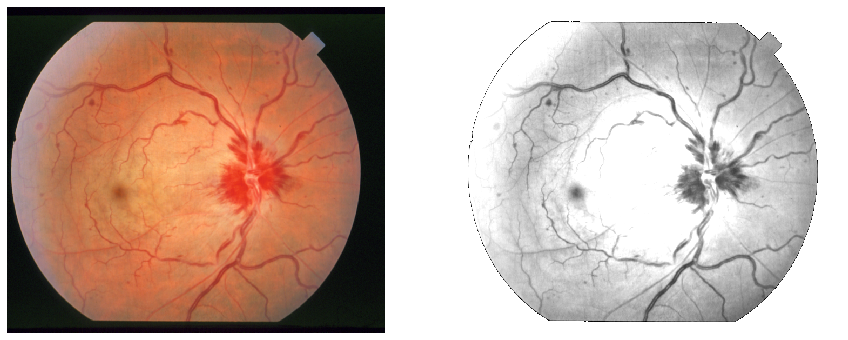

In [6]:
images = [images[4]]
columns = 2
rows = len(images)
fig=plt.figure(figsize=(15, rows * 6))

for img in range(rows):
    
    original_image = plt.imread(folder + images[img])
    show_image(original_image, [rows, columns, img*2 + 1])
    
    processed_image = process_image(original_image)
    show_image(processed_image, [rows, columns, img*2 + 2])
    
plt.show()